# Gaussian Processes in 2D

This article demonstrates how to use Bambi with Gaussian Processes with 2 dimensional predictors. Bambi supports Gaussian Processes through the low-rank approximation known as Hilbert Space Gaussian Processes. For references see [Hilbert Space Methods for Reduced-Rank Gaussian Process Regression](https://arxiv.org/abs/1401.5508) and [Practical Hilbert Space Approximate Bayesian Gaussian Processes for Probabilistic Programming](https://arxiv.org/abs/2004.11408).

For a demonstration of Gaussian Processes in 1D together with a more in depth explanation see **To Do**.

In [9]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

The goal of this notebook is to showcase Bambi's support for Gaussian Processes on two-dimensional data using the HSGP approximation. 

To achieve this, we begin by creating a matrix of coordinates that will serve as the locations where we measure the values of a continuous response variable.

In [10]:
x1 = np.linspace(0, 10, 12)
x2 = np.linspace(0, 10, 12)
xx, yy = np.meshgrid(x1, x2)
X = np.column_stack([xx.flatten(), yy.flatten()])
X.shape

(144, 2)

## Isotropic samples

In modeling multi-dimensional data with a Gaussian Process, we must choose between using an isotropic or an anisotropic Gaussian Process. An isotropic GP applies the same degree of smoothing to all predictors and is rotationally invariant. On the other hand, an anisotropic GP assigns different degrees of smoothing to each predictor and is not rotationally invariant.

Furthermore, as the `hsgp()` function allows for the creation of separate GP contribution terms for the levels of a categorical variable through its `by` argument, we also examine both single-group and multiple-group scenarios.

### A single group

We create a covariance kernel using `ExpQuad` from the `gp` submodule in PyMC. Note that the lengthscale and amplitude for both dimensions are 2 and 1.2, respectively. Then, we simply use NumPy to get a random draw from the 144-dimensional multivariate normal distribution.

(144,) (144, 144)


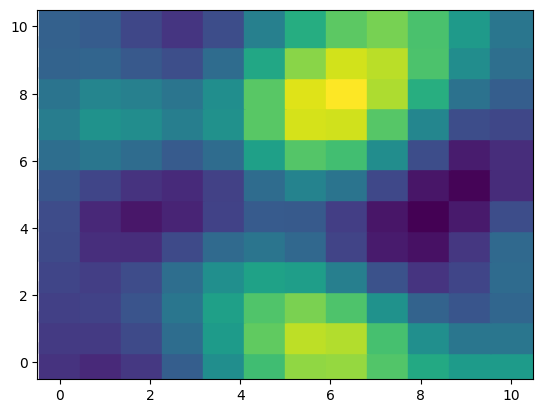

In [11]:
rng = np.random.default_rng(1234)

ell = 2
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])
print(mu.shape, K.shape)

f = rng.multivariate_normal(mu, K)

fig, ax = plt.subplots()
ax.scatter(xx, yy, c=f, s=900, marker="s");

Since Bambi works with long-format data frames, we need to reshape our data before creating the data frame.

In [12]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 1),
        "y": np.tile(yy.flatten(), 1), 
        "outcome": f.flatten()
    }
)

Now, let's construct the model. The only notable distinction from the one-dimensional case is that we provide two unnamed arguments to the `hsgp()` function, representing the predictors on each dimension.

In [13]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, c=1.5, m=10)", data, priors=priors)
model.set_alias({"hsgp(x, y, c=1.5, m=10)": "hsgp"})
model

       Formula: outcome ~ 0 + hsgp(x, y, c=1.5, m=10)
        Family: gaussian
          Link: mu = identity
  Observations: 144
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, c=1.5, m=10)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)

The parameters `c` and `m` of the HSGP aproximation are specific to each dimension, and can have different values for each. However, as we are passing scalars instead of sequences, Bambi will internally recycle them, causing the HSGP approximation to use the same values of `c` and `m` for both dimensions.

Let's build the internal PyMC model and create a graph to have a visual representation of the relationships between the model parameters. 

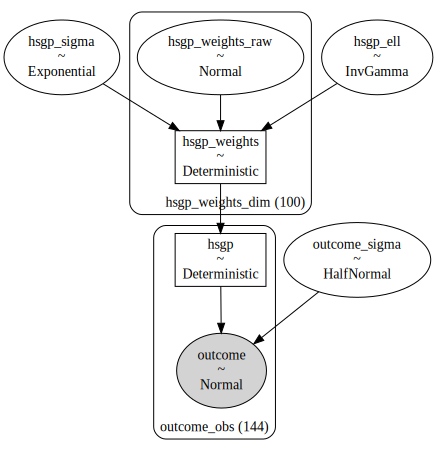

In [14]:
model.build()
model.graph()

And finally, we quickly fit the model and show a traceplot to explore the posterior and spot any issues with the sampler.

In [15]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:02.522713
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:23.313351
Transforming variables...
Transformation time =  0:00:00.628279
0


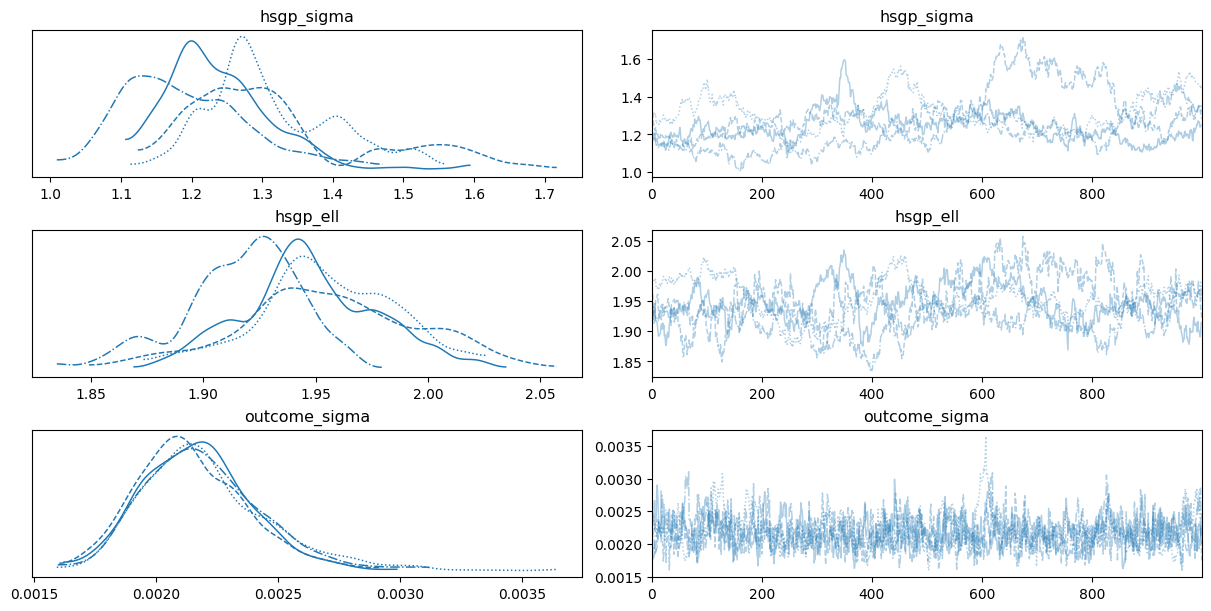

In [16]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

We don't see any divergences. However, the autocorrelation in the chains for the covariance function parameters, along with the insufficient mixing, indicates that there may be an issue with the prior specification of the model.

Since the goal of the notebook is to simply show what features Bambi supports and how to use them, we won't further investigate these issues. However, such posteriors shouldn't be considered in any serious application.

From now on, the notebook will follow the same structure as the one already shown, which consists of

* Data simulation with some specific settings
* Creation of the Bambi model
* Building of the internal PyMC model and visualization of the graph
* Model fit and inspection of the traceplot

### Multiple groups - same covariance function

In this scenario we have multiple groups that share the same covariance function.

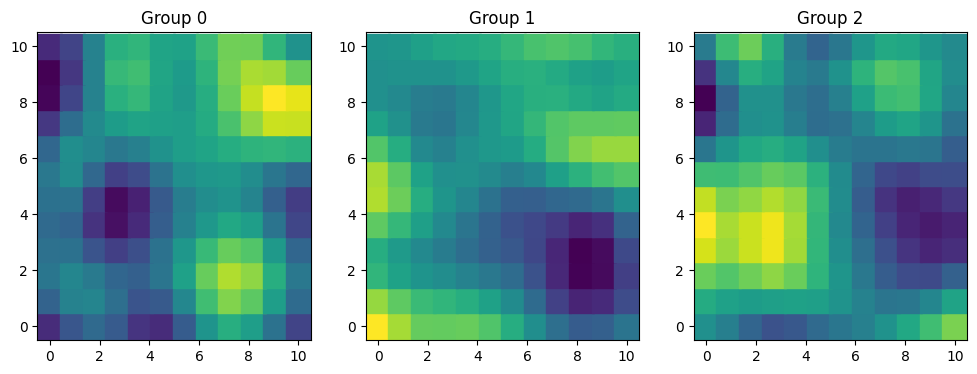

In [17]:
rng = np.random.default_rng(123)

ell = 2
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=320, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [18]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

Notice we don't modify anything substantial in the call to `hsgp()` for now.

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


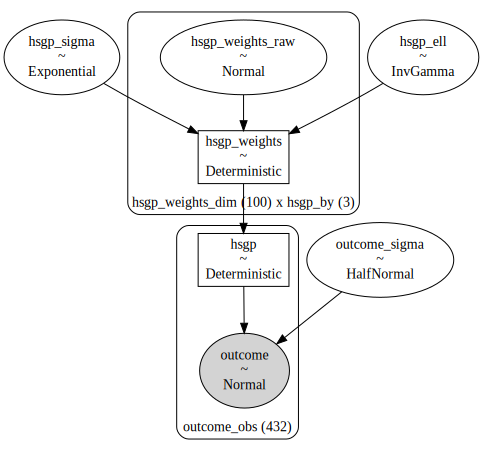

In [19]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10)", data, priors=priors)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10)": "hsgp"})
print(model)
model.build()
model.graph()

In [20]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.721842
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:02:17.782596
Transforming variables...
Transformation time =  0:00:00.838094
0


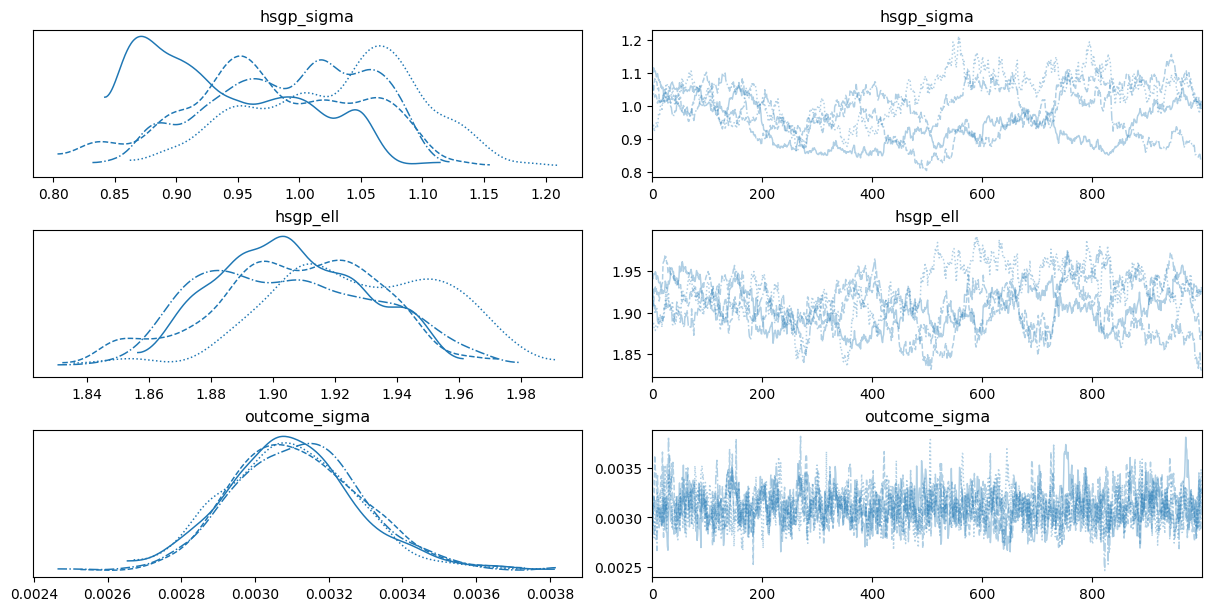

In [21]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

While we have three groups, we only have one `hsgp_sigma` and one `hsgp_ell` for all groups. This is because, by default, the HSGP contributions by groups use the same instance of the covariance function.

### Multiple groups - different covariance function

Again we have multiple groups. But this time, each group has specific values for the amplitude and the lengthscale.

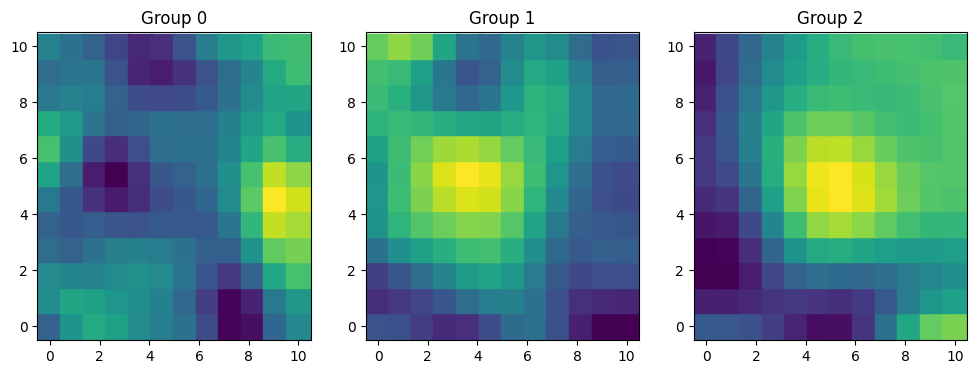

In [22]:
rng = np.random.default_rng(12)

sigmas = [1.2, 1.5, 1.8]
ells = [1.5, 2, 3]

samples = []
for sigma, ell in zip(sigmas, ells):
    cov = sigma * pm.gp.cov.ExpQuad(2, ls=ell)
    K = cov(X).eval()
    mu = np.zeros(X.shape[0])
    samples.append(rng.multivariate_normal(mu, K))

f = np.stack(samples)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=320, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [23]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

In situations like this, we can tell Bambi not to use the same covariance function for all the groups with `share_cov=False` and Bambi will create a separate instance for each group, resulting in group specific estimates of the amplitude and the lengthscale.

Notice, however, we're still using the same kind of covariance function, which in this case is `ExpQuad`.

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


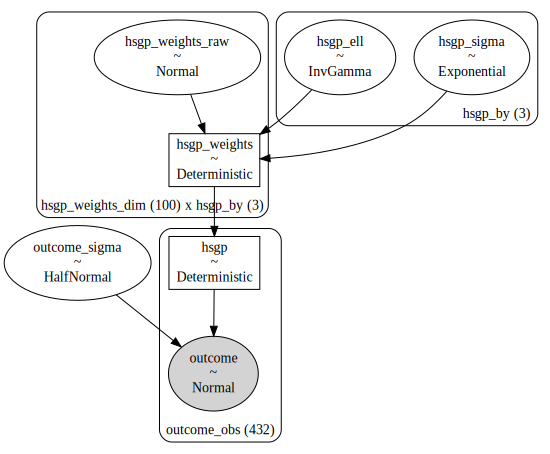

In [24]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model(
    "outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)", 
    data, 
    priors=priors
)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)": "hsgp"})
print(model)
model.build()
model.graph()

See the all the HSGP related parameters gained the new dimension `hsgp_by`.

In [25]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:04.491697
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:02:35.274256
Transforming variables...
Transformation time =  0:00:00.801181
0


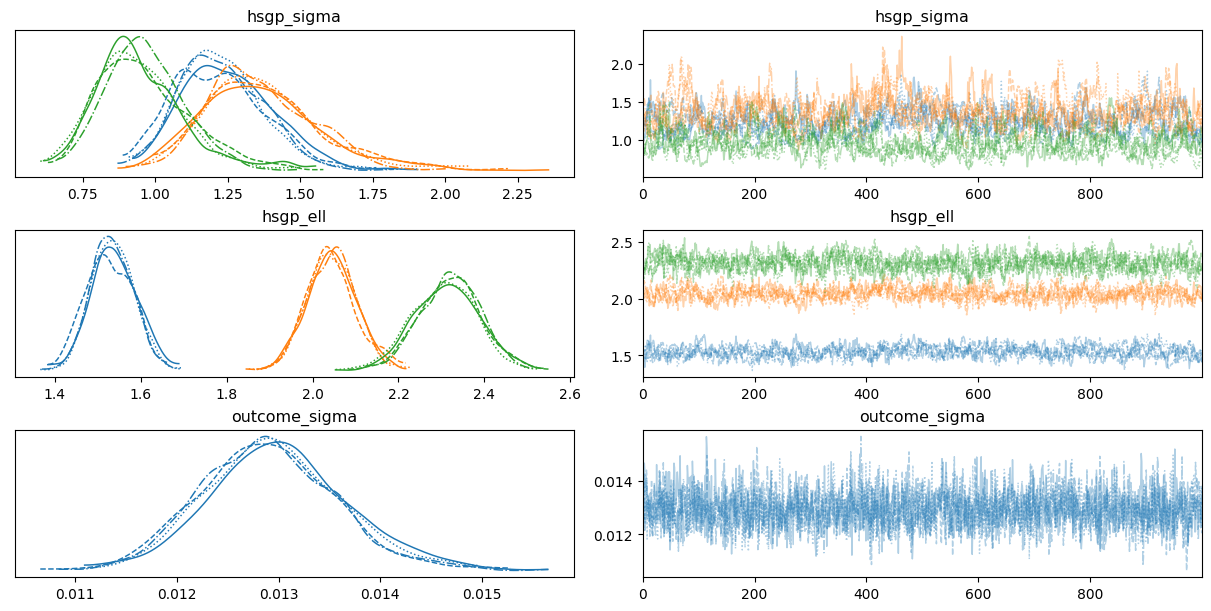

In [26]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

Unlike the previous case, now there are three `hsgp_sigma` and three `hsgp_ell` parameters, one per group. We can see them in different colors in the visualization.

## Anisotropic samples

In this second part we repeat exactly the same that we did for the isotropic case. First, we start with a single group. Then, we continue with multiple groups that share the covariance function. And finally, multiple groups with different covariance functions. The main difference is that we use `iso=False`, which asks to use an anisotropic GP.

### A single group

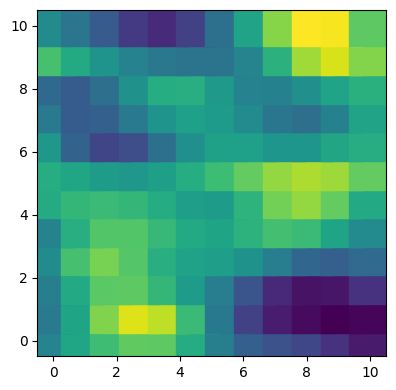

In [27]:
rng = np.random.default_rng(1234)

ell = [2, 0.9]
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K)

fig, ax = plt.subplots(figsize = (4.5, 4.5))
ax.scatter(xx, yy, c=f, s=900, marker="s");

In [28]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 1),
        "y": np.tile(yy.flatten(), 1), 
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, c=1.5, m=10, iso=False)
        Family: gaussian
          Link: mu = identity
  Observations: 144
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, c=1.5, m=10, iso=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


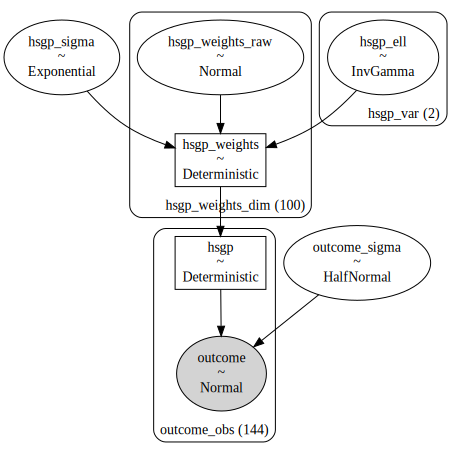

In [29]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, c=1.5, m=10, iso=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, c=1.5, m=10, iso=False)", data, priors=priors)
model.set_alias({"hsgp(x, y, c=1.5, m=10, iso=False)": "hsgp"})
print(model)
model.build()
model.graph()

Although there is only one group in this case, the graph includes a `hsgp_var` dimension. This dimension represents the variables in the HSGP component, indicating that there is one lengthscale parameter per variable.

In [30]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.320646
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.159032
Transforming variables...
Transformation time =  0:00:00.173091
0


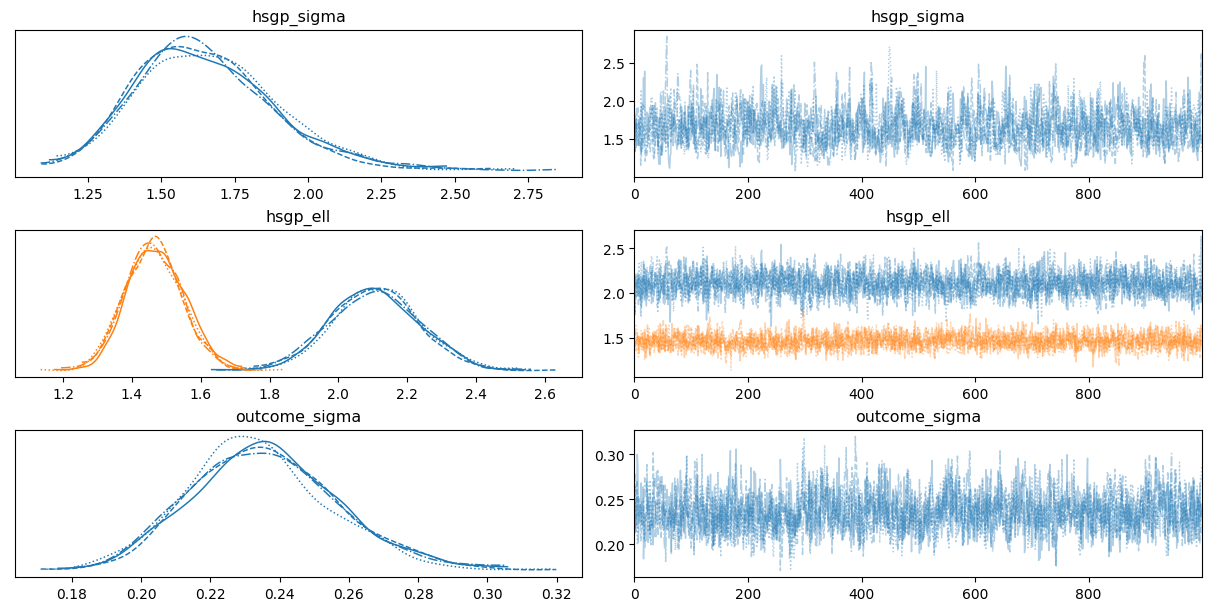

In [31]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - same covariance function

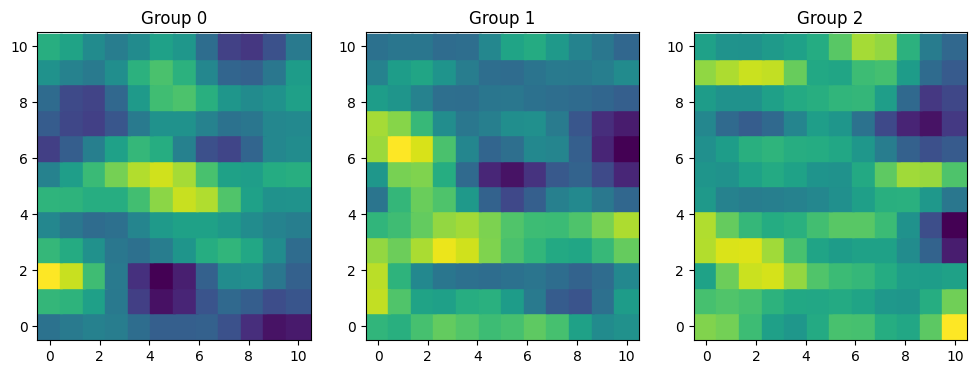

In [32]:
rng = np.random.default_rng(123)

ell = [2, 0.9]
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=320, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [33]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10, iso=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


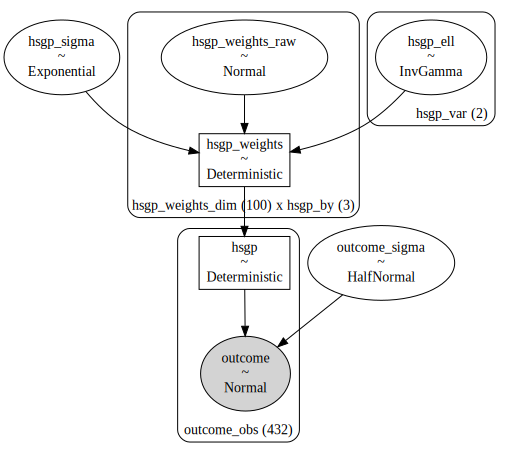

In [34]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, iso=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False)", data, priors=priors)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, iso=False)": "hsgp"})
print(model)
model.build()
model.graph()

In [35]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.464203
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:17.674547
Transforming variables...
Transformation time =  0:00:00.249682
0


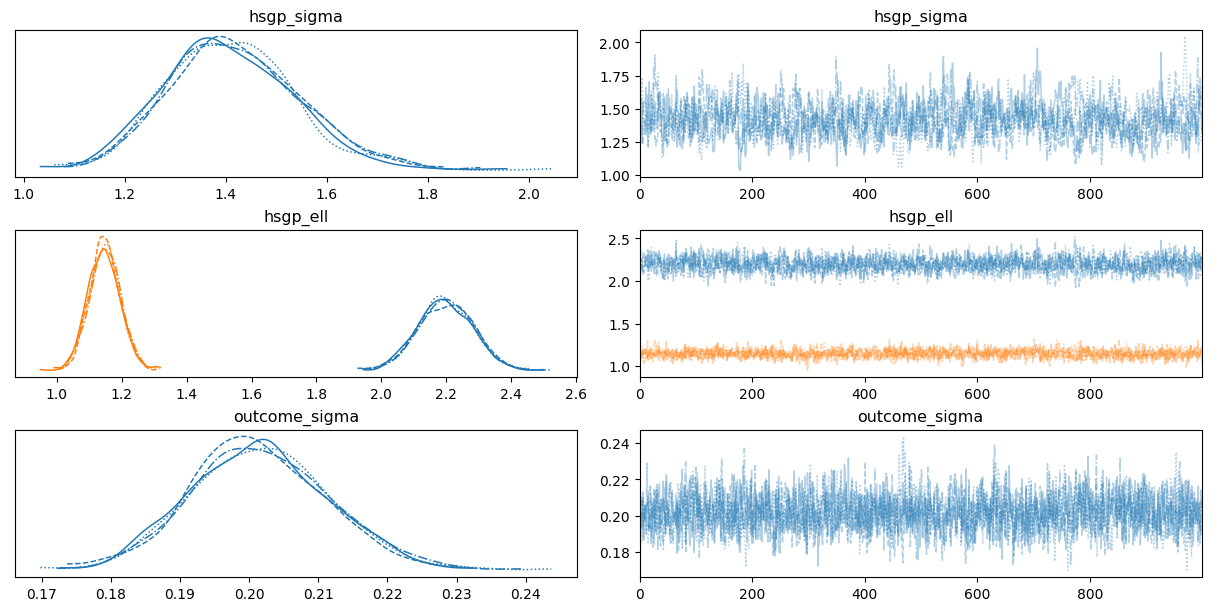

In [36]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - different covariance function

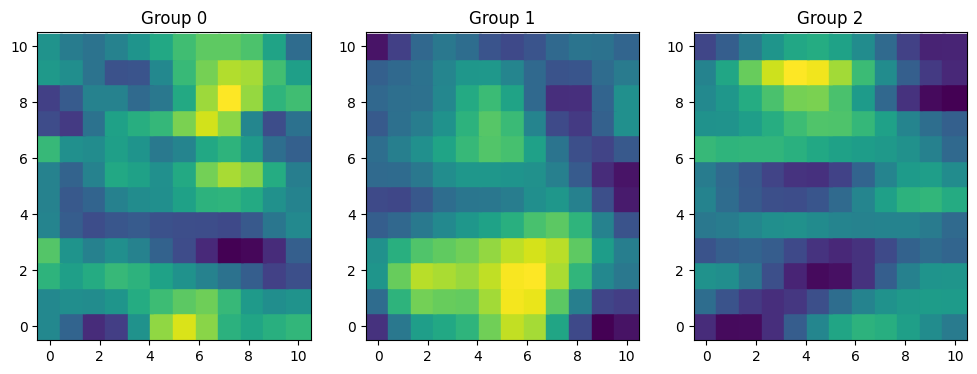

In [37]:
rng = np.random.default_rng(12)

sigmas = [1.2, 1.5, 1.8]
ells = [[1.5, 0.8], [2, 1.5], [3, 1]]

samples = []
for sigma, ell in zip(sigmas, ells):
    cov = sigma * pm.gp.cov.ExpQuad(2, ls=ell)
    K = cov(X).eval()
    mu = np.zeros(X.shape[0])
    samples.append(rng.multivariate_normal(mu, K))

f = np.stack(samples)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=320, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [38]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


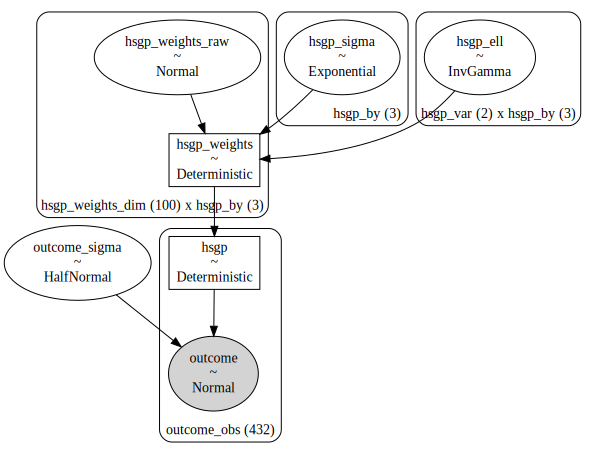

In [39]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model(
    "outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)", 
    data, 
    priors=priors
)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)": "hsgp"})
print(model)
model.build()
model.graph()

In [40]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:03.955870
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:20.713181
Transforming variables...
Transformation time =  0:00:00.513813
0


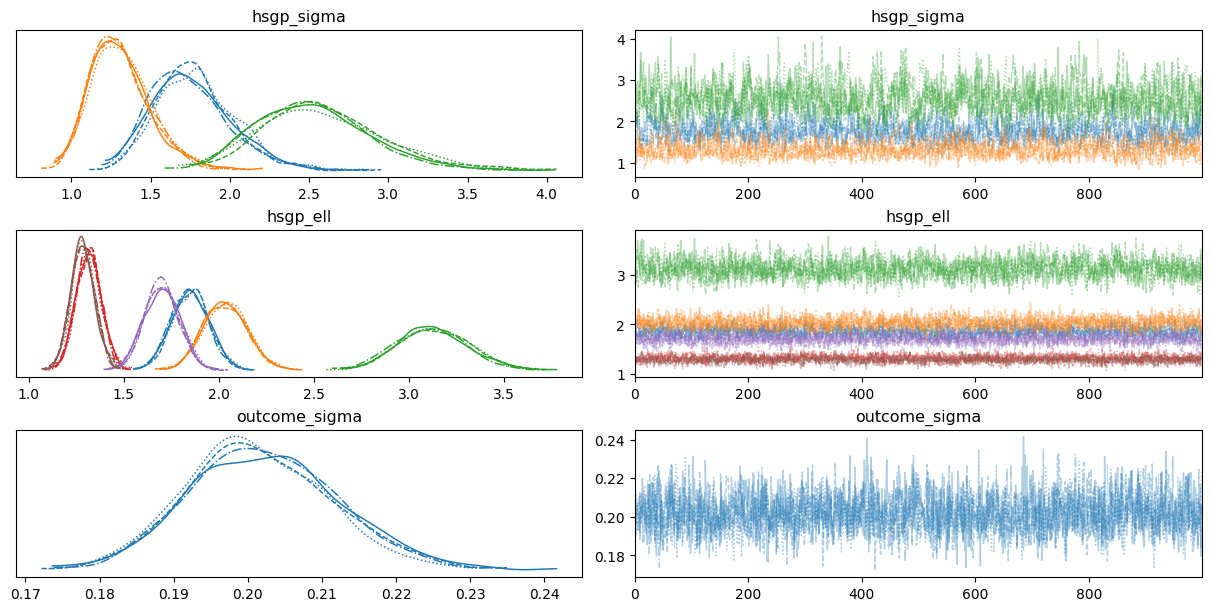

In [41]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

## A more complex example: Poisson likelihood with group-specific effects

For this final demonstration we're going to use a simulated dataset where the outcome is a count variable. For the predictors, we have the location in terms of the latitude and longitude, as well as other variables such as the year of the measurement, the site where the measure was made, and one continuous predictor.

In [42]:
data = pd.read_csv("data/poisson_data.csv")
data["Year"] = pd.Categorical(data["Year"])
print(data.shape)
data.head()

(100, 6)


,Year,Count,Site,Lat,Lon,X1
0,2015,4,Site1,47.559880,7.216754,3.316140
1,2016,0,Site1,47.257079,7.135390,2.249612
2,2015,0,Site1,47.061967,7.804383,2.835283
3,2016,0,Site1,47.385533,7.433145,2.776692
4,2015,1,Site1,47.034987,7.434643,2.295769


We can visualize the outcome variable by location and year.

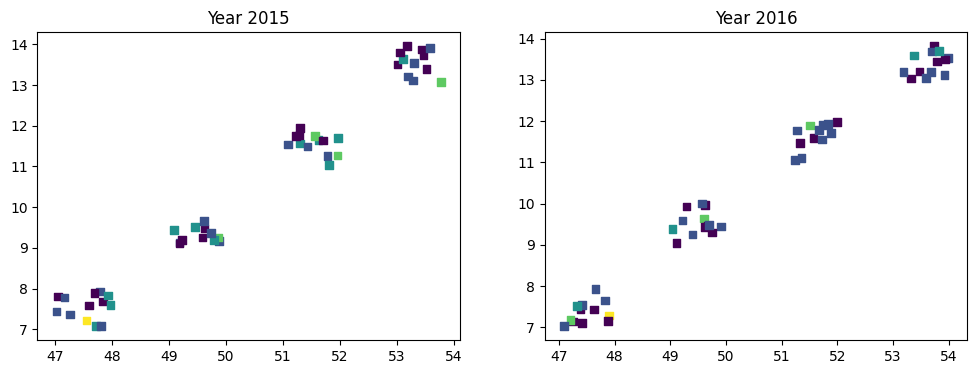

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax, year) in enumerate(zip(axes, [2015, 2016])):
    mask = data["Year"] == year
    x = data.loc[mask, "Lat"]
    y = data.loc[mask, "Lon"]
    count = data.loc[mask, "Count"]
    ax.scatter(x, y, c=count, s=30, marker="s")
    ax.set_title(f"Year {year}")

There's not much we can conclude from here but it's not a problem. The most relevant part of the example is not the data itself, but how to use Bambi to include GP components in a complex model.

It's very easy to create a model that uses both regular common and group-specific predictors as well as a GP contribution term. We just add them to the model formula, treat `hsgp()` as any other call, and that's it!

Below we have common effects for the Year, the interaction between X1 and Year, and group-specific intercepts by Site. Finally, we add `hsgp()` as any other call.

In [44]:
formula = "Count ~ 0 + Year + X1:Year + (1|Site) + hsgp(Lon, Lat, by=Year, m=5, c=1.5)"
model = bmb.Model(formula, data, family="poisson")
model

       Formula: Count ~ 0 + Year + X1:Year + (1|Site) + hsgp(Lon, Lat, by=Year, m=5, c=1.5)
        Family: poisson
          Link: mu = log
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Year ~ Normal(mu: [0. 0.], sigma: [5. 5.])
            X1:Year ~ Normal(mu: [0. 0.], sigma: [1.5693 1.4766])
        
        Group-level effects
            1|Site ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.3683))
        
        HSGP contributions
            hsgp(Lon, Lat, by=Year, m=5, c=1.5)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ InverseGamma(alpha: 3.0, beta: 2.0)

Let's use an alias to make the graph representation more readable.

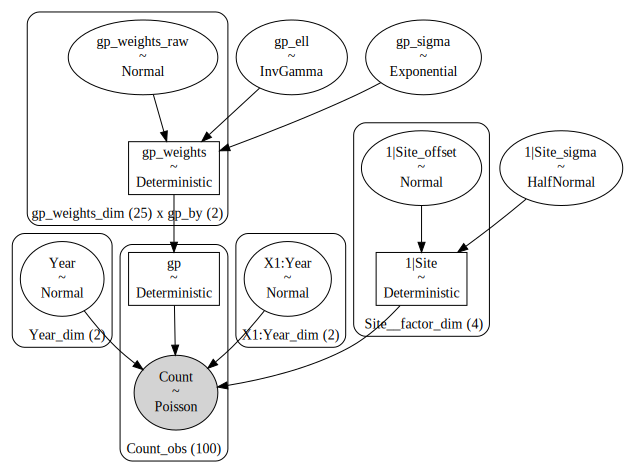

In [45]:
model.set_alias({"hsgp(Lon, Lat, by=Year, m=5, c=1.5)": "gp"})
model.build()
model.graph()

And finally, let's fit the model.

In [46]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.99)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:04.433012
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:09.698066
Transforming variables...
Transformation time =  0:00:00.668909
15


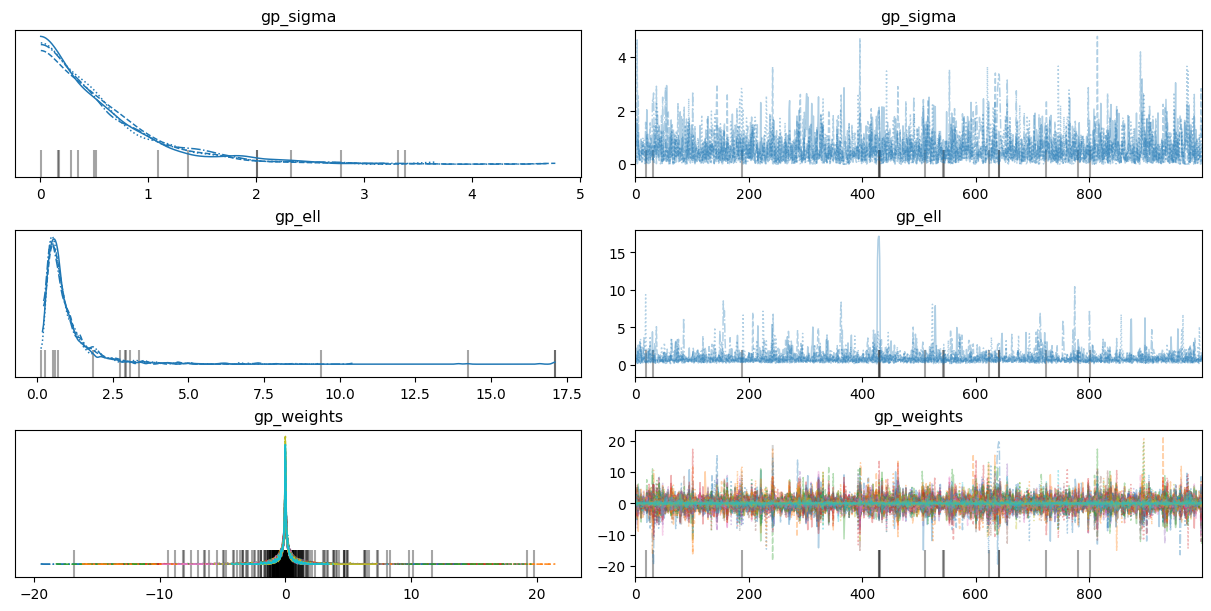

In [47]:
az.plot_trace(
    idata, 
    var_names=["gp_sigma", "gp_ell", "gp_weights"], 
    backend_kwargs={"layout": "constrained"}
);

Notice the posteriors for the `gp_weights` are all centered at zero. This is a symptom of the absence of any spatial effect. 

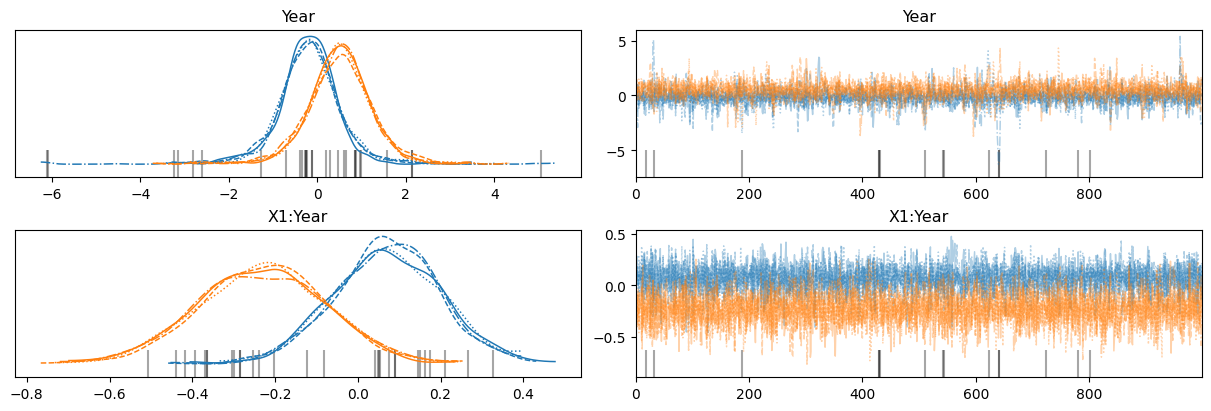

In [48]:
az.plot_trace(
    idata, 
    var_names=["Year", "X1:Year"], 
    backend_kwargs={"layout": "constrained"}
);

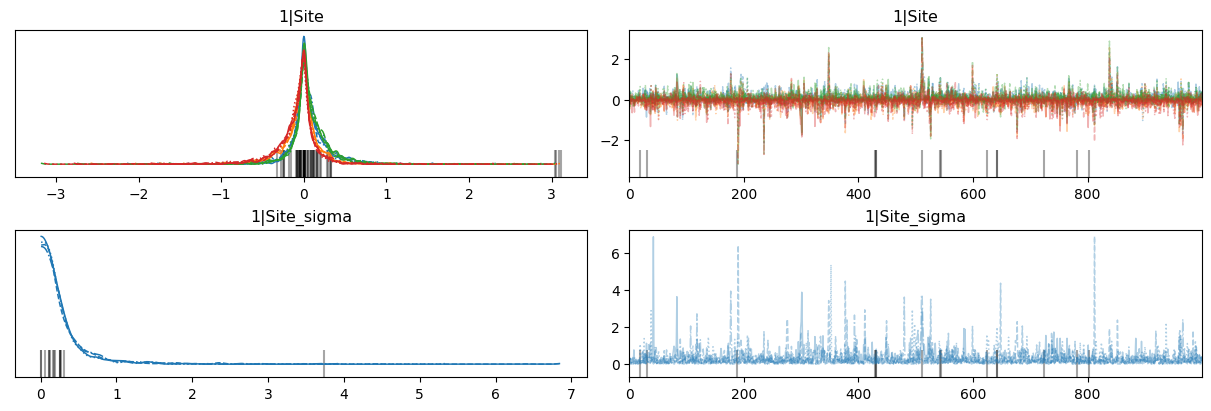

In [49]:
az.plot_trace(
    idata, 
    var_names=["1|Site", "1|Site_sigma"], 
    backend_kwargs={"layout": "constrained"}
);